In [41]:
# Library import
import pandas as pd
import numpy as np
from scipy import stats
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import squarify

from sklearn.metrics import *

In [42]:
# PEP8 Checker
# %load_ext pycodestyle_magic
# %pycodestyle_on

# Objectives:

- Clustering e-commerce data with unsupervised Machine Learning algorithms
- Taking a similar approach than RFM clustering
- Evaluate relevance & Identify particularities of clusters
- Evaluate temporal stability of the model to propose maintainance plan

# Data loading

In [43]:
df = pd.read_csv('data/DRV_customer_clustering.csv')
df_orders = pd.read_csv('data/DRV_orders.csv')

In [44]:
df.head(10)

,customer_unique_id,last_purchase_date,recency,frequency,monetary_value,mean_order_delivery_days,mean_order_volume_cm3,avg_review_score,main_product_category,main_payment_type,p_voucher_use,mean_payment_installments,customer_city_size
0,000bfa1d2f1a41876493be685390d6d3,2017-09-29 14:46:58,335,2,93.70,14.0,2646.0,4.5,fashion_bags_accessories,credit_card,0.0,4.0,419400.0
1,004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54,228,2,354.37,6.5,33792.0,5.0,cool_stuff,credit_card,0.0,2.0,796257.0
2,00a39521eb40f7012db50455bf083460,2018-06-03 10:12:57,88,2,123.25,17.5,3960.0,4.0,electronics,credit_card,0.0,1.0,2570160.0
3,00cc12a6d8b578b8ebd21ea4e2ae8b27,2017-03-21 19:25:23,526,4,252.40,6.5,23625.0,4.0,bed_bath_table,boleto,0.0,1.0,11253503.0
4,011575986092c30523ecb71ff10cb473,2018-04-18 21:58:08,133,2,214.90,13.5,13500.0,3.5,musical_instruments,credit_card,0.0,1.5,2375151.0
5,011b4adcd54683b480c4d841250a987f,2018-02-15 11:40:57,196,2,236.30,12.5,5760.0,4.5,food,credit_card,0.0,8.0,57800.0
6,012452d40dafae4df401bced74cdb490,2018-05-14 12:12:45,108,2,495.33,10.0,70434.0,4.5,health_beauty,credit_card,0.5,3.0,11253503.0
7,012a218df8995d3ec3bb221828360c86,2018-06-18 13:08:38,73,2,1510.38,5.0,20539.0,3.5,auto,credit_card,0.5,5.5,15733.0
8,013ef03e0f3f408dd9bf555e4edcdc0a,2018-07-20 04:13:54,41,2,245.37,3.0,13440.0,5.0,musical_instruments,credit_card,0.0,2.0,1080113.0
9,013f4353d26bb05dc6652f1269458d8d,2017-11-28 13:30:58,275,2,356.39,10.0,22620.0,5.0,sports_leisure,credit_card,0.0,3.0,556642.0


In [45]:
# Check missing values in the dataset
missing_values_count = df.isnull().sum()

print(missing_values_count[missing_values_count > 0])

Series([], dtype: int64)


In [46]:
# Print top 5 rows and shape of dataframe
display(df.head())
print('{:,} rows; {:,} columns'
      .format(df.shape[0], df.shape[1]))

,customer_unique_id,last_purchase_date,recency,frequency,monetary_value,mean_order_delivery_days,mean_order_volume_cm3,avg_review_score,main_product_category,main_payment_type,p_voucher_use,mean_payment_installments,customer_city_size
0,000bfa1d2f1a41876493be685390d6d3,2017-09-29 14:46:58,335,2,93.70,14.0,2646.0,4.5,fashion_bags_accessories,credit_card,0.0,4.0,419400.0
1,004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54,228,2,354.37,6.5,33792.0,5.0,cool_stuff,credit_card,0.0,2.0,796257.0
2,00a39521eb40f7012db50455bf083460,2018-06-03 10:12:57,88,2,123.25,17.5,3960.0,4.0,electronics,credit_card,0.0,1.0,2570160.0
3,00cc12a6d8b578b8ebd21ea4e2ae8b27,2017-03-21 19:25:23,526,4,252.40,6.5,23625.0,4.0,bed_bath_table,boleto,0.0,1.0,11253503.0
4,011575986092c30523ecb71ff10cb473,2018-04-18 21:58:08,133,2,214.90,13.5,13500.0,3.5,musical_instruments,credit_card,0.0,1.5,2375151.0


2,833 rows; 13 columns


In [47]:
# Making lastu purchase date a datetime type
df.loc[:, 'last_purchase_date'] = pd.to_datetime(df.
                                                 loc[:, 'last_purchase_date'])

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833 entries, 0 to 2832
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customer_unique_id         2833 non-null   object        
 1   last_purchase_date         2833 non-null   datetime64[ns]
 2   recency                    2833 non-null   int64         
 3   frequency                  2833 non-null   int64         
 4   monetary_value             2833 non-null   float64       
 5   mean_order_delivery_days   2833 non-null   float64       
 6   mean_order_volume_cm3      2833 non-null   float64       
 7   avg_review_score           2833 non-null   float64       
 8   main_product_category      2833 non-null   object        
 9   main_payment_type          2833 non-null   object        
 10  p_voucher_use              2833 non-null   float64       
 11  mean_payment_installments  2833 non-null   float64       
 12  custom

# Clustering based on RFM methodology

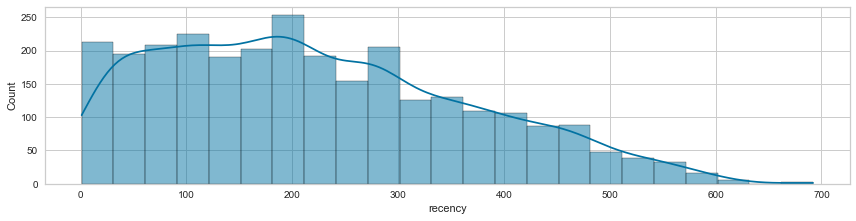

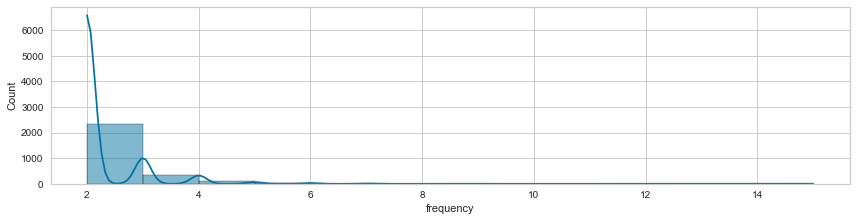

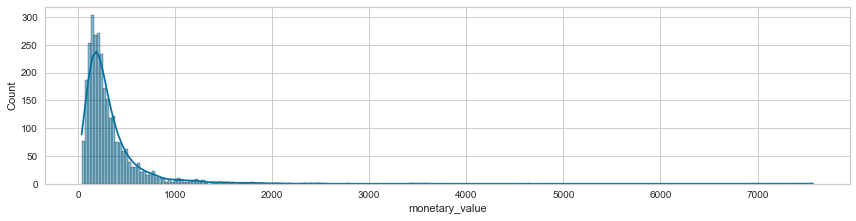

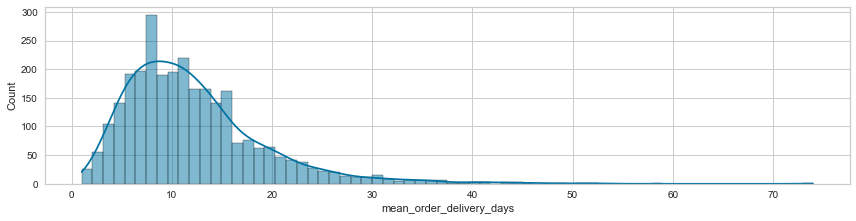

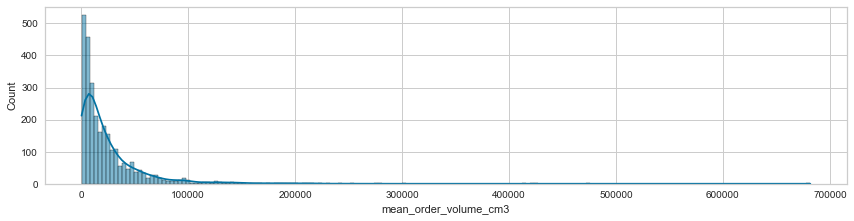

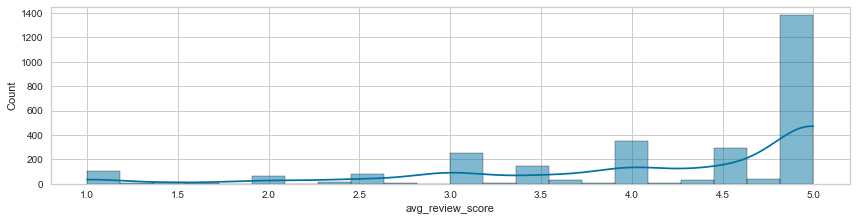

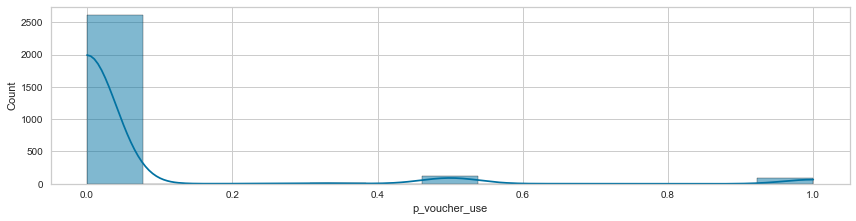

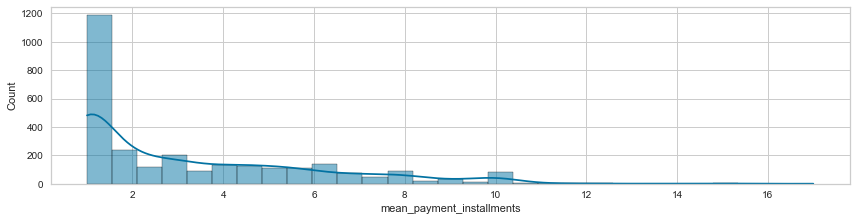

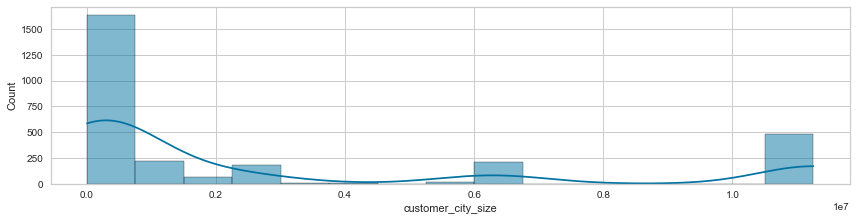

In [49]:
# Show distribution of all possible features
for i, col in enumerate(df.iloc[:, 2:]
                        .select_dtypes(exclude='object').columns):
    # Plot RFM distributions
    plt.figure(figsize=(12, (df.shape[1] - 2) * 3))
    # Plot distribution of recency
    plt.subplot(df.shape[1] - 2, 1, i+1)
    sns.histplot(df[col],
                 kde=True)
    plt.tight_layout()
    plt.show()

In [50]:
# Function for barchart with associated percentage

def barchart_percent(x, data, figsize, rotation=False):
    # Barchart visualisation
    plt.figure(figsize=figsize)
    ax = sns.countplot(x=x,
                       data=data)
    # Add percentage for each bar
    total = len(data)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    # If factor name is to longue, possibility of ticks roation
    if rotation == True:
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

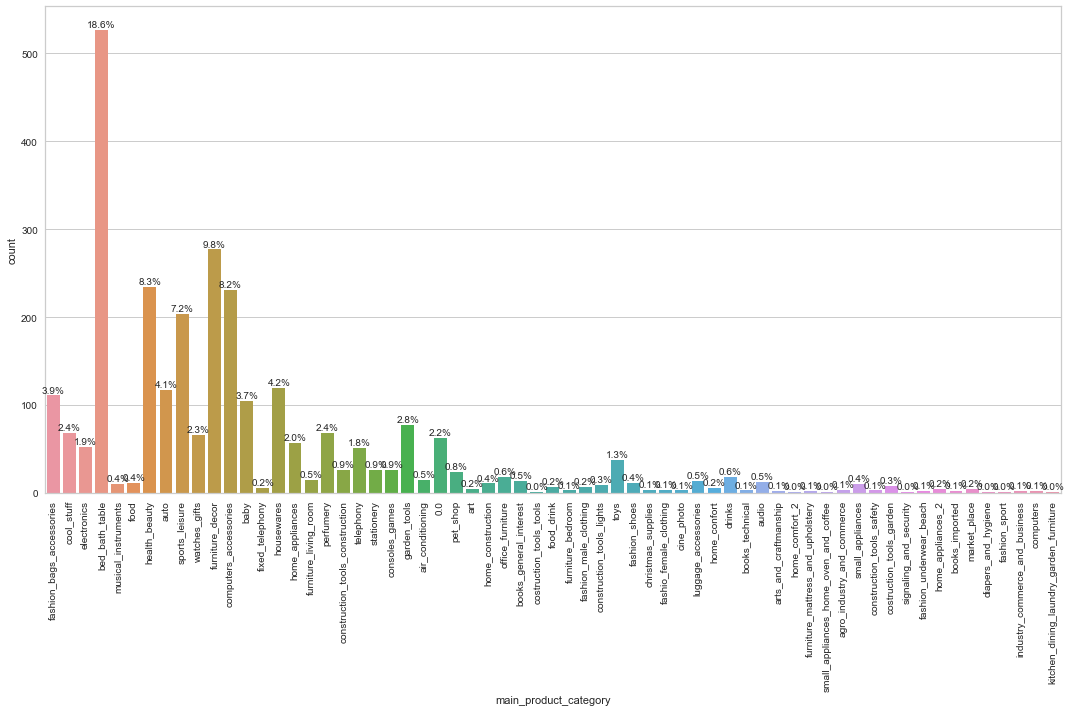

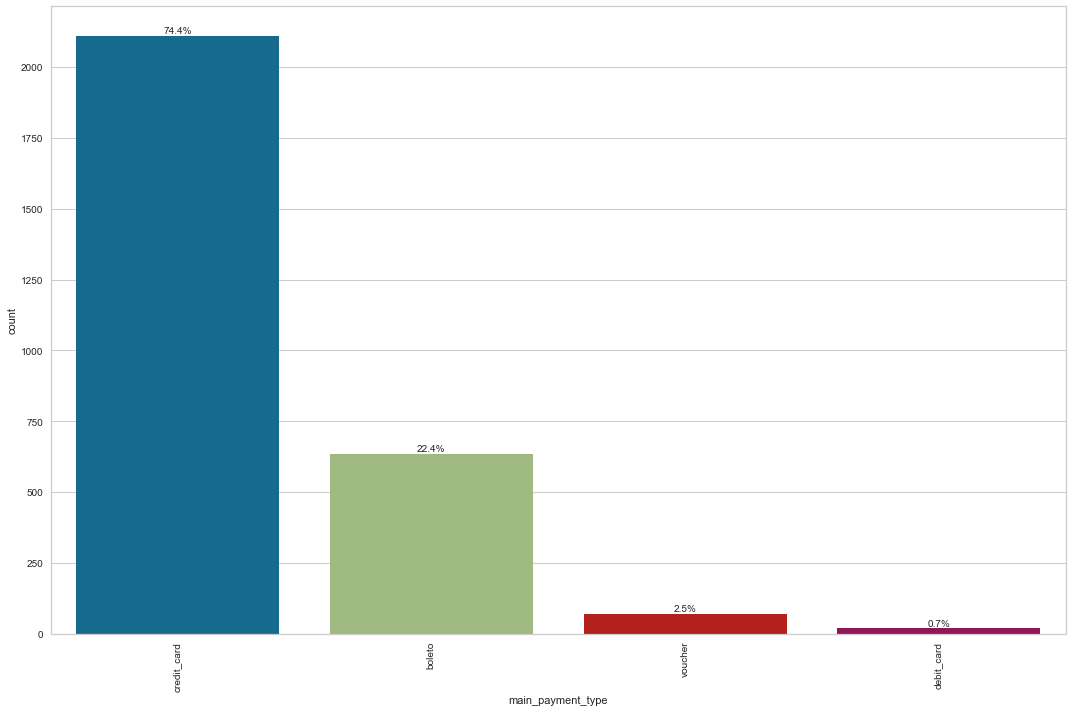

In [51]:
# Show distribution of all possible features
for i, col in enumerate(df.iloc[:, 2:]
                        .select_dtypes(include='object').columns):
    plt.figure(figsize=(15, 10))
    ax = sns.countplot(x=col,
                       data=df)
    total = len(df)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

## K-mean Clustering

- First, we have selected data and features according to **RFM**:

    - **Recency** – How recently did the customer purchase?
    - **Frequency** – How often do they purchase?
    - **Monetary Value** – How much do they spend?
    
- However, it give poor cluster so we decide to add other features to the clustering:
    - Features based on the customer
        - **Average review score** the mean review score gave by the customer, which represente the client **satisfaction**
        - **Customer city size** a geographical information on the customer

In [52]:
# Selection of the good features
selected_features = ['recency',
                     'frequency',
                     'monetary_value',
                     'avg_review_score',
                     'customer_city_size']

In [53]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

from sklearn.compose import ColumnTransformer, make_column_transformer

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance

In [54]:
# Preprocessing of features
scaler = StandardScaler()

preprocessor = ColumnTransformer([('standard-scaler',
                                   scaler,
                                   selected_features)])

X_scaled = preprocessor.fit_transform(df)

X_scaled

array([[ 0.78084688, -0.38091538, -0.68623094,  0.28039543, -0.58604665],
       [ 0.03792882, -0.38091538,  0.08399968,  0.74849835, -0.49560867],
       [-0.93411351, -0.38091538, -0.59891627, -0.18770749, -0.0699082 ],
       ...,
       [ 1.69734392, -0.38091538, -0.76216958, -1.12391333, -0.42748903],
       [ 0.88499427,  1.06953257, -0.55060511,  0.12436112, -0.67823577],
       [ 2.02367242, -0.38091538, -0.72635727, -1.12391333, -0.67983091]])

### Evaluation of cluster's number 

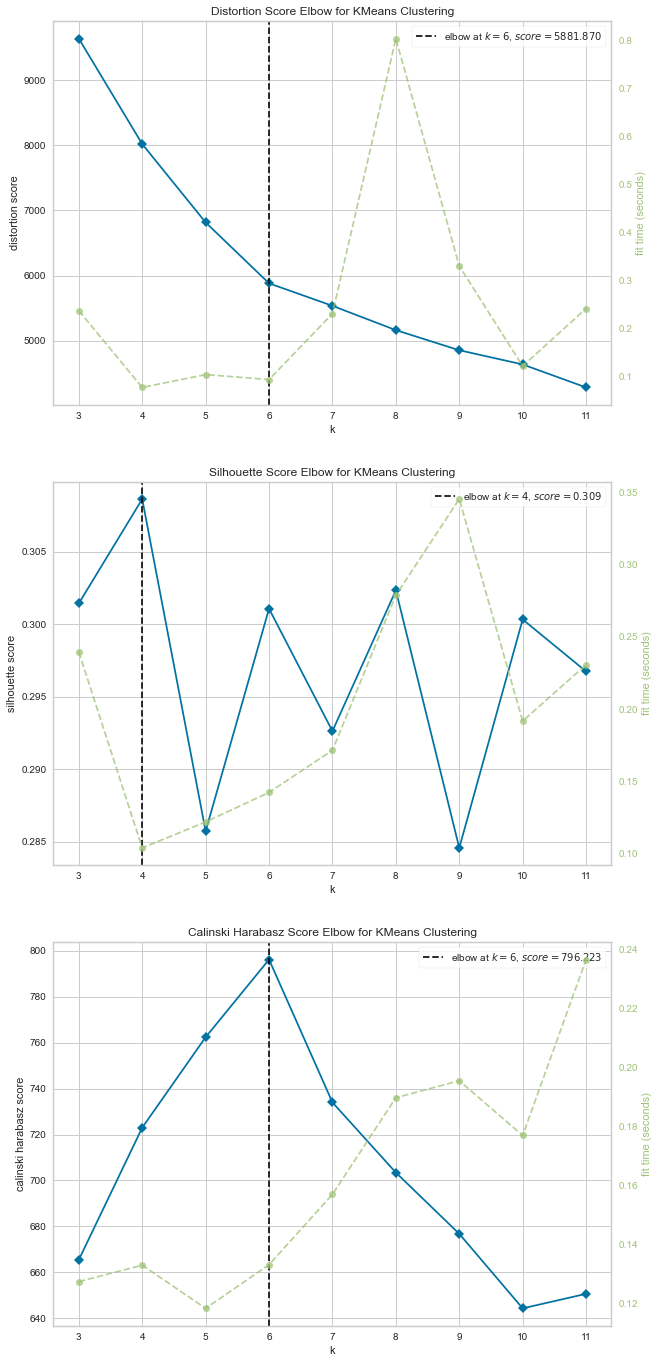

In [55]:
# Elbow method with differents metrics
metrics = ["distortion", "silhouette", "calinski_harabasz"]
i = 0

# Model fitting
model = KMeans(max_iter=1000,
               n_init=10,
               random_state=123)

fig, axes = plt.subplots(nrows=3,
                         ncols=1,
                         sharex=False,
                         sharey=False,
                         figsize=(10, 24))

# Plot for each differents metrics
for m in metrics:
    kmeans_visualizer = KElbowVisualizer(model,
                                         k=(3, 12),
                                         metric=m,
                                         ax=axes[i])
    kmeans_visualizer.fit(X_scaled)
    kmeans_visualizer.finalize()
    i += 1

plt.show()

The elbow method suggests to separate client into 6 clusters. We are going to use silouhette score to double check this results for 2 to 6 clusters.

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In this example the silhouette analysis is used to choose an optimal value for n_clusters. The silhouette plot shows that the n_clusters value of 3, 5 and 6 are a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 2 and 4.

Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 when n_clusters is equal to 2, is bigger in size owing to the grouping of the 3 sub clusters into one big cluster. However when the n_clusters is equal to 4, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right.

/Users/franck/opt/anaconda3/envs/P5_devenv/lib/python3.9/site-packages/sklearn/manifold/_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


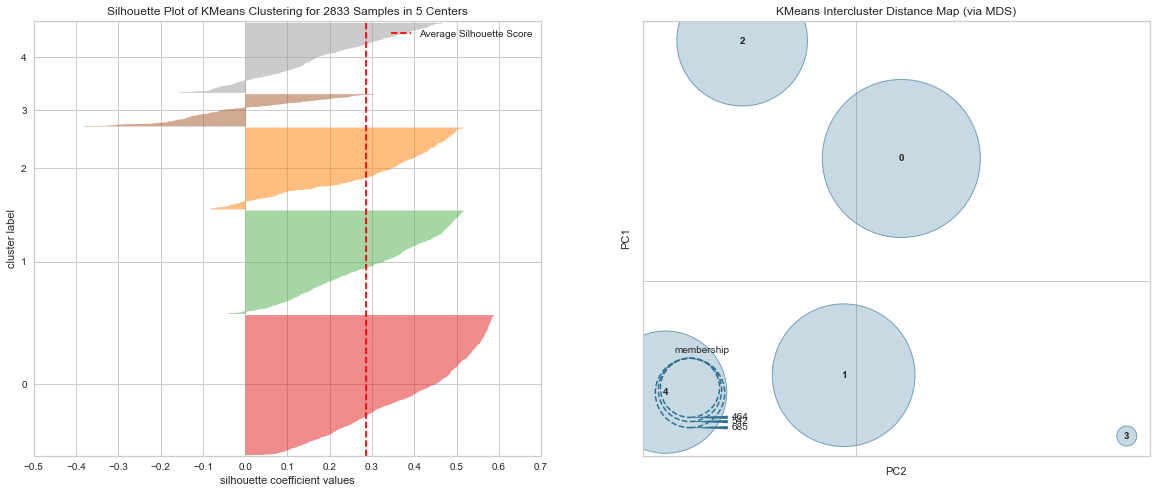

For n_clusters = 5 The average silhouette_score is : 0.2857164121706901 



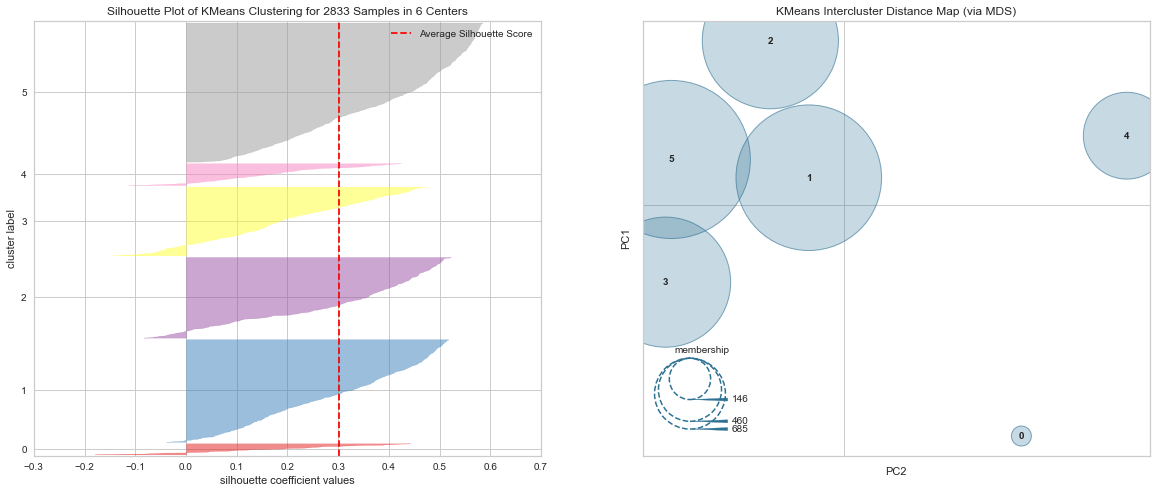

For n_clusters = 6 The average silhouette_score is : 0.30107561017005524 



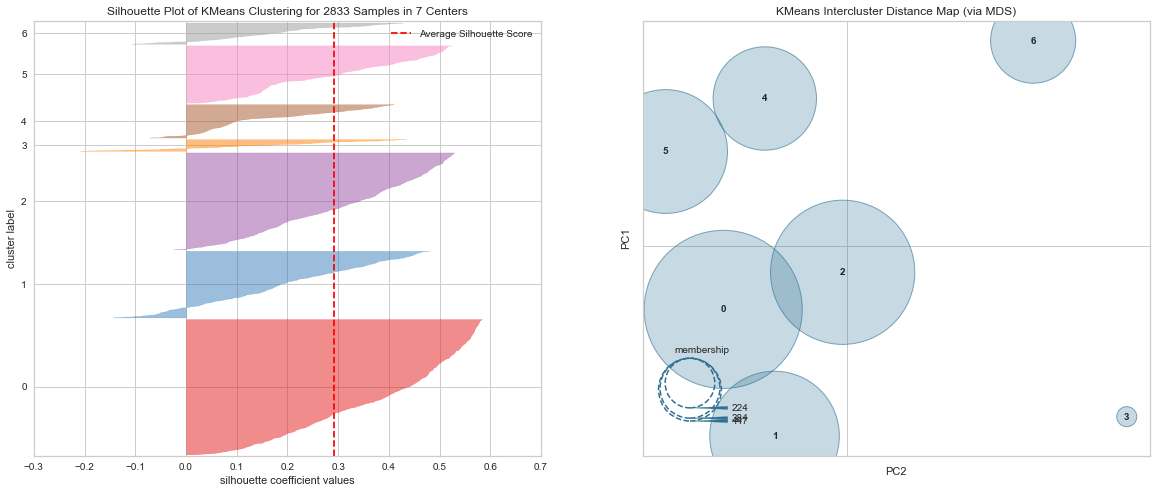

For n_clusters = 7 The average silhouette_score is : 0.292627372947292 



In [56]:
# Silouhette score evaluation and visualisation
#   & Intercluster distance Map with best k
for k in range(5, 8):
    
    # Initialize the clusterer with k clusters value and a random generator
    # seed of 123 for reproducibility.
    model = KMeans(n_clusters=k,
                   max_iter=1000,
                   n_init=10,
                   random_state=123)
    cluster_labels = model.fit_predict(X_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters    
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)

    fig, axes = plt.subplots(nrows=1,
                             ncols=2,
                             sharex=False,
                             sharey=False,
                             figsize=(20, 8))

    visualizer = SilhouetteVisualizer(model,
                                      ax=axes[0])
    distance_visualizer = InterclusterDistance(model,
                                               ax=axes[1])
    visualizer.fit(X_scaled)
    distance_visualizer.fit(X_scaled)

    visualizer.finalize()
    distance_visualizer.show()
    
    print(
    "For n_clusters =",
    k,
    "The average silhouette_score is :",
    silhouette_avg, '\n'
    )

Those evaluations shows that 5 clusters could be better. Indeed, it is the maximum number of cluster where they are not too close to each others

#### Low dimension visualisation

PCA is a classical multivariate (unsupervised machine learning) non-parametric dimensionality reduction method that used to interpret the variation in high-dimensional interrelated dataset (dataset with a large number of variables)
PCA reduces the high-dimensional interrelated data to low-dimension by linearly transforming the old variable into a new set of uncorrelated variables called principal component (PC) while retaining the most possible variation.
The first component has the largest variance followed by the second component and so on. The first few components retain most of the variation, which is easy to visualize and summarise the feature of original high-dimensional datasets in low-dimensional space. PCA helps to assess which original samples are similar and different from each other.
PCA preserves the global data structure by forming well-separated clusters but can fail to preserve the similarities within the clusters.
PCA works better in revealing linear patterns in high-dimensional data but has limitations with the nonlinear dataset. The t-SNE can be used for dimensionality reduction for nonlinear datasets.
For example, when datasets contain 10 variables (10D), it is arduous to visualize them at the same time (you may have to do 45 pairwise comparisons to interpret dataset effectively). PCA transforms them into a new set of variables (PCs) with top PCs having the highest variation. PCs are ordered which means that the first few PCs (generally first 3 PCs but can be more) contribute most of the variance present in the the original high-dimensional dataset. These top first 2 or 3 PCs can be plotted easily and summarize and the features of all original 10 variables.

In [57]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [58]:
def two_dim_viz(X, model):

    # Fit the model and define clusters
    model = model.fit(X)
    cluster_labels = model.predict(X)

    # Create 2D TSNE and PCA features
    X_tsne = TSNE(n_components=2,
                  perplexity=30,
                  n_iter=300,
                  learning_rate=300,
                  early_exaggeration=12,
                  n_jobs=-1,
                  init='pca').fit_transform(X)

    pca = PCA(2)
    X_reduced = pca.fit_transform(X)

    # Plot creation
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_tsne[:, 0],
                    y=X_tsne[:, 1],
                    hue=cluster_labels,
                    legend="brief",
                    s=100,
                    palette='Set1'
                    )
    plt.xlabel("")
    plt.ylabel("")
    plt.title("t-SNE clusters representation")
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_reduced[:, 1],
                    y=X_reduced[:, 0],
                    hue=cluster_labels,
                    legend="brief",
                    palette='Set1',
                    s=100
                    )
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.xlabel("F1")
    plt.ylabel("F2")
    plt.title("PCA clusters representation")

    plt.legend()

/Users/franck/opt/anaconda3/envs/P5_devenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/franck/opt/anaconda3/envs/P5_devenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/franck/opt/anaconda3/envs/P5_devenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


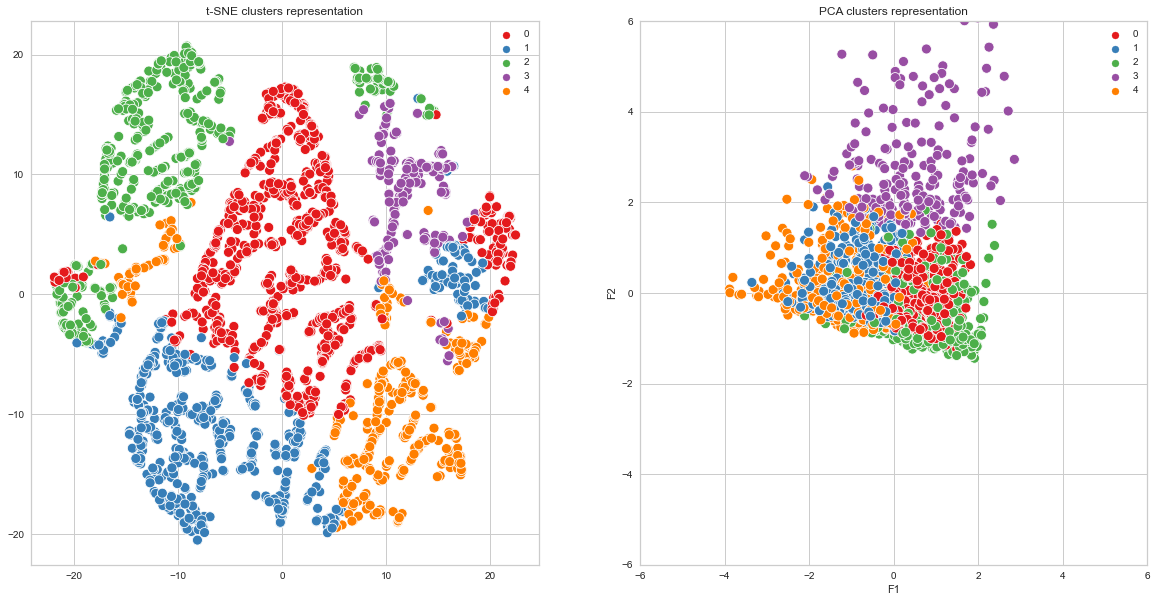

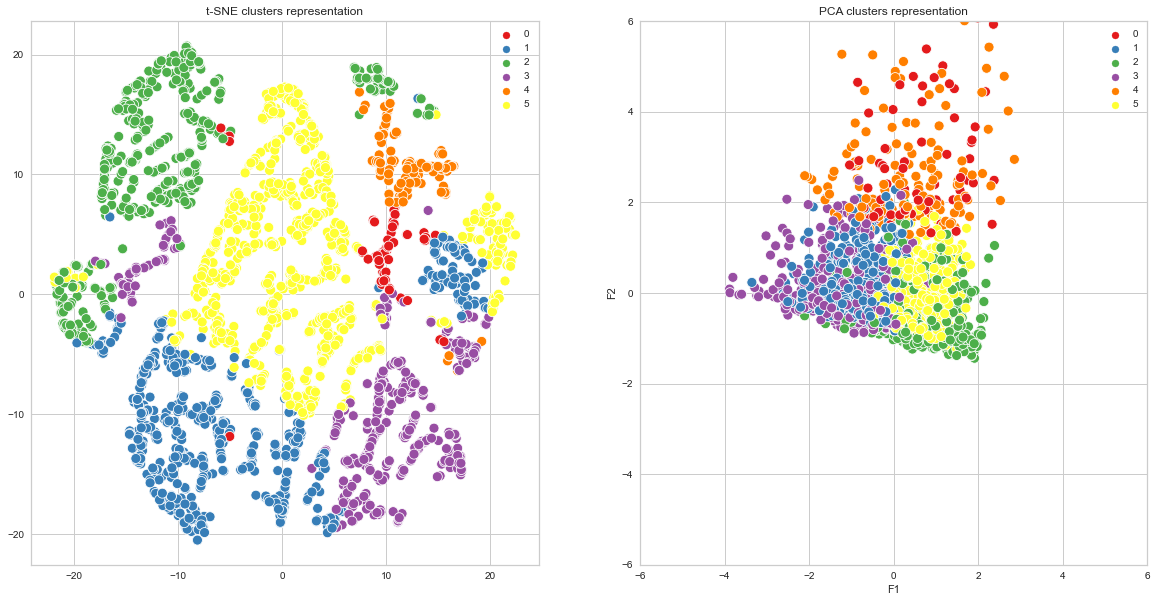

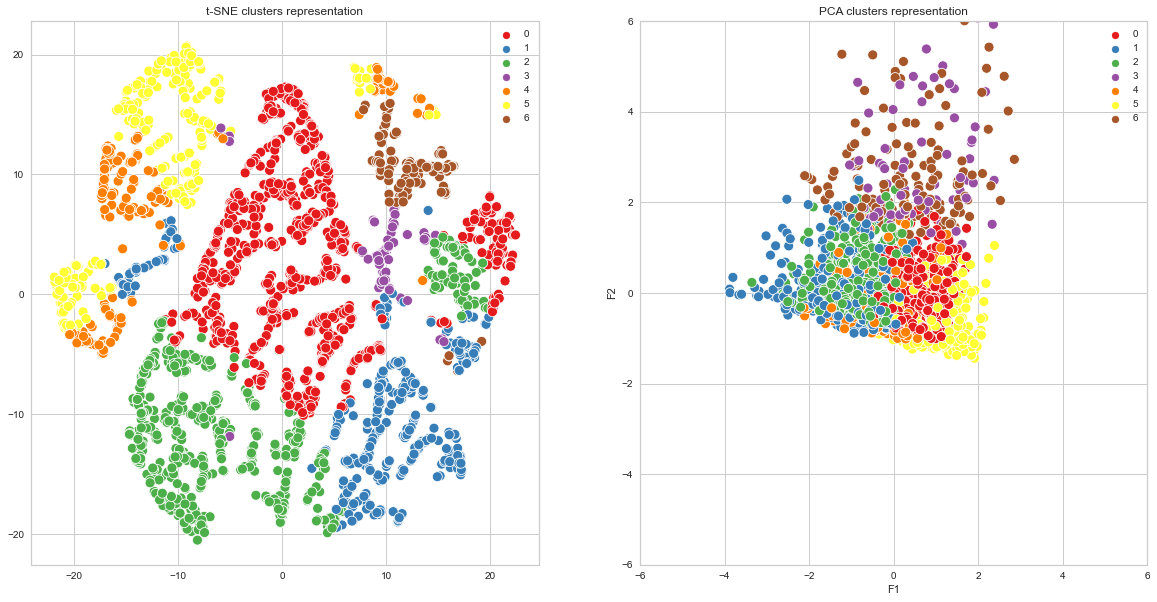

In [59]:
# Show visualisation with dimension reduction for different number of cluster
for k in range(5, 8):
    two_dim_viz(X=X_scaled,
                model=KMeans(n_clusters=k,
                             max_iter=1000,
                             n_init=10,
                             random_state=123))

In biplot, the PC loadings and scores are plotted in a single figure, biplots are useful to visualize the relationships between variables and observations


In [60]:
# Function to create PCA correlation circle

def cerle_corr(n_comp, pca, axis_ranks,
               labels=None, label_rotation=0):

    pcs = pca.fit(X_scaled).components_

    fig = plt.figure(figsize=(20, n_comp*5))
    count = 1
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # plot init
            fig.subplots_adjust(left=0.1,
                                right=0.9,
                                bottom=0.1,
                                top=0.9)
            ax = plt.subplot(int(n_comp / 2), 2, count)
            ax.set_aspect('equal', adjustable='box')

            # Gaphics limit definition
            ax.set_xlim(-1, 1)
            ax.set_ylim(-1, 1)

            # shows arrow
            ax.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                      pcs[d1, ], pcs[d2, :],
                      angles='xy', scale_units='xy', scale=1,
                      color="grey", alpha=0.5)
            # and variable name
            for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                ax.annotate(labels[i], (x, y),
                            ha='center', va='center',
                            fontsize='14', color="#17aafa", alpha=0.8)

            # add axis
            ax.plot([-1, 1], [0, 0], linewidth=1, color='grey', ls='--')
            ax.plot([0, 0], [-1, 1], linewidth=1, color='grey', ls='--')

            # add circle
            cercle = plt.Circle((0, 0), 1, color='#17aafa', fill=False)
            ax.add_artist(cercle)

            # axis name, and explicate inertia percentage
            ax.set_xlabel('F{} ({}%)'
                          .format(d1+1,
                                  round(100*pca
                                        .explained_variance_ratio_[d1], 1)))
            ax.set_ylabel('F{} ({}%)'
                          .format(d2+1,
                                  round(100*pca
                                        .explained_variance_ratio_[d2], 1)))

            ax.set_title("Correlation circle (F{} and F{})".format(d1+1, d2+1))
            count += 1

    plt.suptitle("Correlation circle of {} first axes".format(n_comp),
                 y=.9, color="blue", fontsize=18)
    plt.show(block=False)

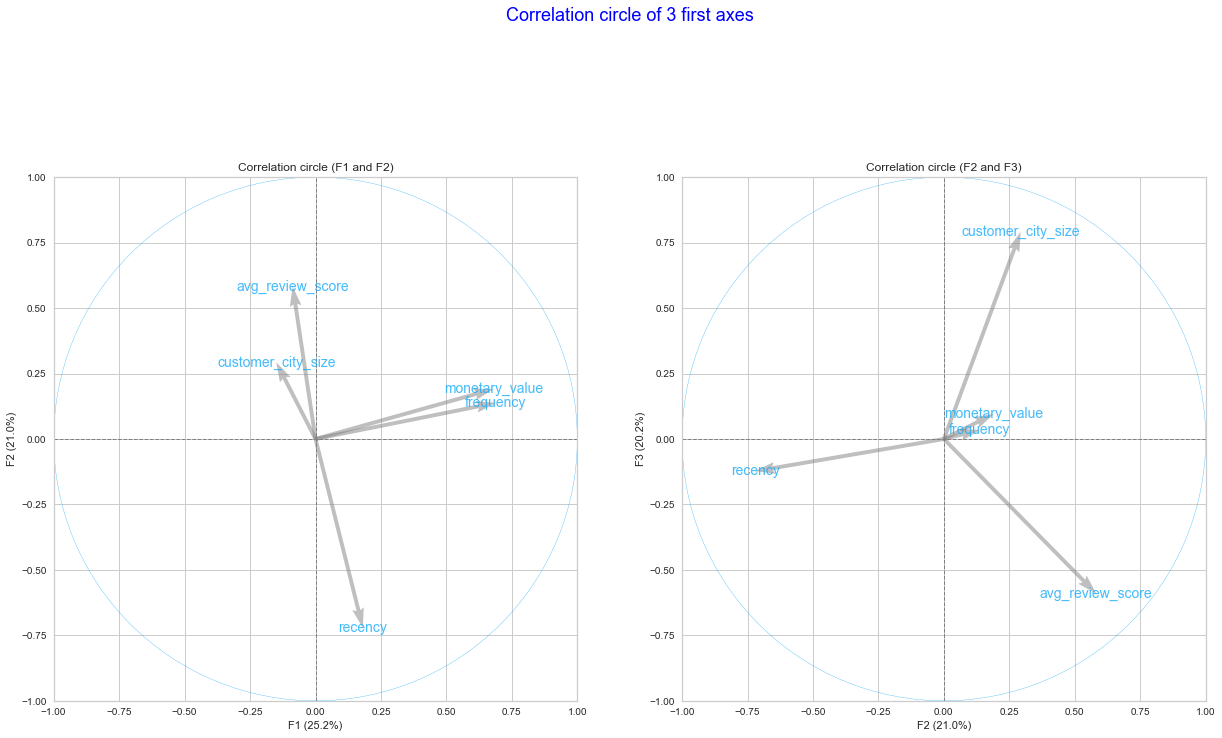

In [61]:
# Plot correlation circle
cerle_corr(n_comp=3,
           pca=PCA(3),
           axis_ranks=[(0, 1), (1, 2)],
           labels=np.array(df[selected_features].columns))

## Conclusion

Despite the fact that the elbow method shows that 6 clusters is better, I will keep 5 clusters to avoid small and overlap clusters

### Clusters labeling and evaluation

The purpose of this section is to analyse cluster in order to give them a label

In [62]:
df_rfm = df.loc[:, selected_features]

In [63]:
# Best model fitting
best_model = KMeans(n_clusters=5,
                    max_iter=1000,
                    n_init=10,
                    random_state=0)

best_model.fit_transform(X_scaled)
df_rfm.loc[:, ('cluster')] = best_model.predict(X_scaled)

In [64]:
# Save model as a pickle file
import pickle

with open('pickle_model', 'wb') as file:
    pickle.dump(best_model, file)

scaler.fit(df[selected_features])
with open('pickle_scaler', 'wb') as file:
    pickle.dump(scaler, file)

In [65]:
# Open the saved model
# with open('pickle_model', 'rb') as file:
#    best_model = pickle.load(file)

In [66]:
# Calculate average values for each RFM cluster,
# and return a size of each segment
df_rfm_agg = df_rfm.groupby('cluster').agg({
    'recency': ['mean', 'max', 'min'],
    'frequency': ['mean'],
    'monetary_value': ['mean'],
    'avg_review_score': ['mean'],
    'customer_city_size': ['mean', 'count']
}).round(1)

# In order to have all features evlving the same I will put recency as negative
df_rfm.loc[:, 'recency'] = - df_rfm.loc[:, 'recency']
# Print the aggregated dataset

display(df_rfm_agg)

recency           frequency monetary_value avg_review_score  \
           mean  max  min      mean           mean             mean   
cluster                                                               
0         379.4  692  246       2.2          253.5              4.6   
1         114.6  248    1       2.1          272.5              4.7   
2         200.0  592    1       2.1          266.4              4.5   
3         222.0  585    4       2.1          330.9              2.3   
4         247.4  601    7       3.9          932.7              4.3   

        customer_city_size        
                      mean count  
cluster                           
0                 828996.6   685  
1                 674580.0   929  
2               10231768.6   542  
3                1936818.3   464  
4                2195735.7   213

In [67]:
# Function to have spider chart
import plotly.graph_objs as go


def plot_radars(data, group, highlight=False, which='none'):

    # Find the mean for each group
    data = data.groupby(group).mean()
    
    # We use a MinMaxScaler to scale each features
    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data),
                        index=data.index,
                        columns=data.columns).reset_index()

    fig = go.Figure()

    # if highlight is true the choosen cluster can be 'highlighted'
    if highlight == True:
        for k in data[group]:
            if which == k:
                fig.add_trace(go.Scatterpolar(
                    r=data[data[group] == k].iloc[:, 1:].values.reshape(-1),
                    theta=data.columns[1:],
                    fill='toself',
                    name='Cluster ' + str(k),
                    opacity=1
                ))
            else:
                fig.add_trace(go.Scatterpolar(
                    r=data[data[group] == k].iloc[:, 1:].values.reshape(-1),
                    theta=data.columns[1:],
                    fill='toself',
                    name='Cluster ' + str(k),
                    opacity= 0.2
                ))
    else:
        for k in data[group]:
            fig.add_trace(go.Scatterpolar(
                r=data[data[group] == k].iloc[:, 1:].values.reshape(-1),
                theta=data.columns[1:],
                fill='toself',
                
                name='Cluster ' + str(k)
            ))
            

    fig.update_layout(
        autosize=False,
        width=600,
        height=600,
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Cluster's profile comparison",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="black",
        title_font_size=18)

    fig.show()

In [68]:
plot_radars(data=df_rfm,
            group='cluster',
            highlight=False,
            which=0)

for i in range(0, 5):
    plot_radars(data=df_rfm,
                group='cluster',
                highlight=True,
                which=i)

#### Univariate cluster visualisation

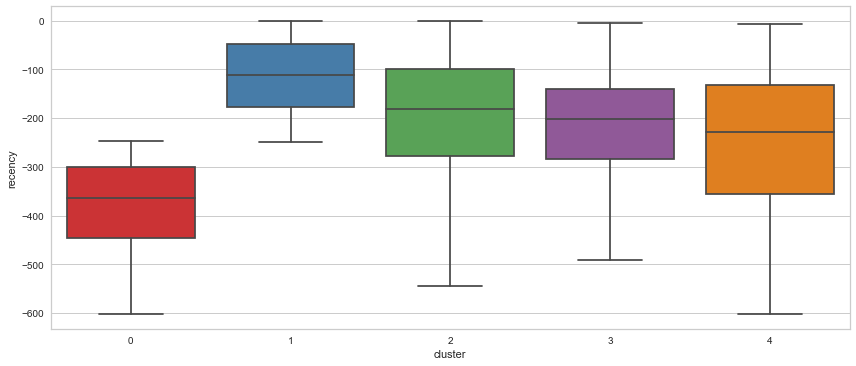

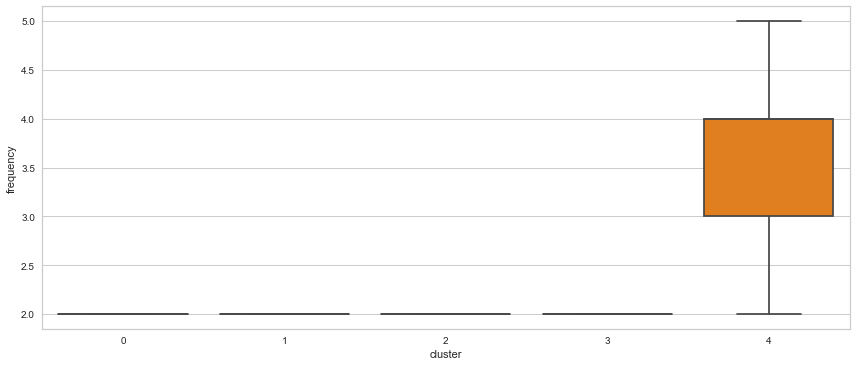

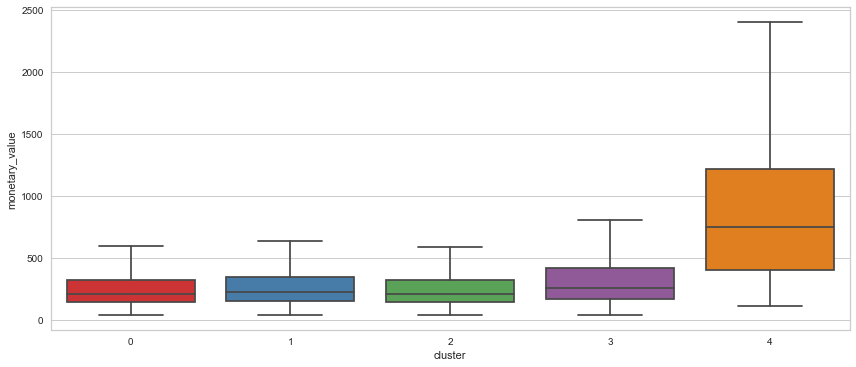

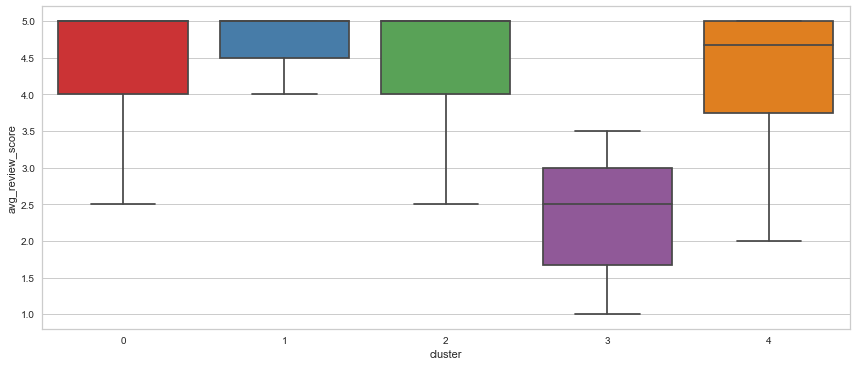

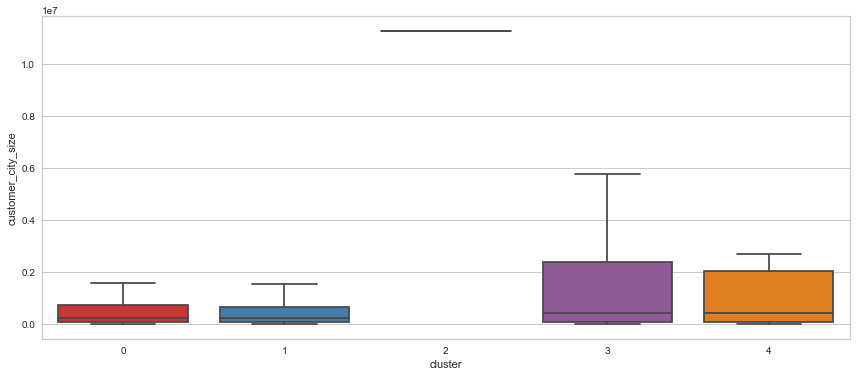

In [69]:
# Boxplot of each featurs per cluster
for i, col in enumerate(df_rfm.iloc[:, :-1].columns):
    plt.figure(figsize=(12, (df_rfm.shape[1]) * 5))
    plt.subplot(df_rfm.shape[1], 1, i+1)
    sns.boxplot(data=df_rfm,
                y=col,
                x='cluster',
                palette='Set1',
                showfliers = False)
    plt.tight_layout()
plt.show()

Those boxplot allow to compare each features distribution in fonction of cluster. It help do find any particular caracteristic for each cluster. By exemple for the city size. It easy to see that the cluster 3 is totally differente from other. 

#### Bivariate clusters visualisation

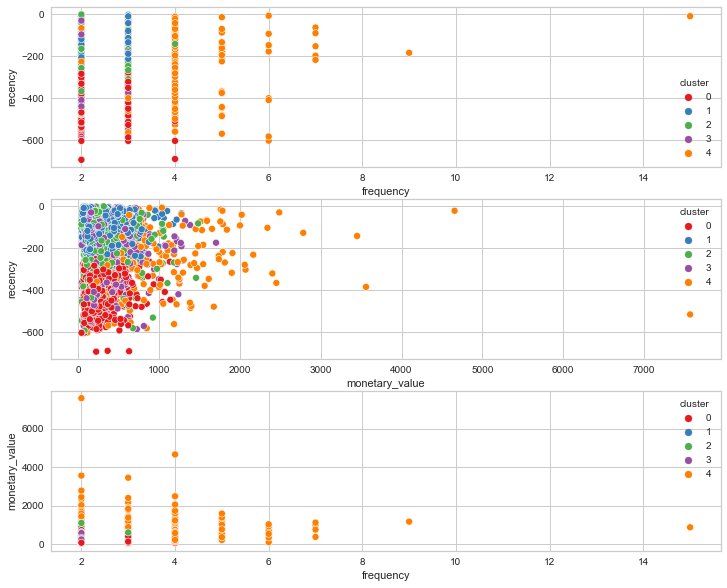

In [70]:
# Scatter plot of each feature 2 by 2
plt.figure(figsize=(12, 10))

# Plot boxplot of recency
plt.subplot(3, 1, 1)
sns.color_palette("Set2")
sns.scatterplot(data=df_rfm,
                y='recency',
                x='frequency',
                hue='cluster',
                palette='Set1')

# Plot distribution of frequency
plt.subplot(3, 1, 2)
sns.scatterplot(data=df_rfm,
                y='recency',
                x='monetary_value',
                hue='cluster',
                palette='Set1')

plt.subplot(3, 1, 3)
sns.scatterplot(data=df_rfm,
                y='monetary_value',
                x='frequency',
                hue='cluster',
                palette='Set1')
# Show the plot
plt.show()

#### Multivariate clusters visualisation

In [71]:
import matplotlib.colors

In [72]:
# Create hex code colors palatte from Set1
import plotly.express as px


my_color = []


def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb


for i, value in enumerate(px.colors.qualitative.Set1):
    value = value.replace('rgb(', "")
    value = value.replace(')', "")
    value = value.split(",")

    nb1 = int(value[0])
    nb2 = int(value[1])
    nb3 = int(value[2])

    my_color.append('#' + rgb_to_hex((nb1, nb2, nb3)))

In [73]:
# 3D Scatter plot of all RFM features with clustering
fig = px.scatter_3d(df_rfm,
                    x='frequency',
                    y='recency',
                    z='monetary_value',
                    opacity=0.7,
                    color=df_rfm['cluster'].astype('str').sort_values(axis=0),
                    color_discrete_sequence=my_color)

# tight layout
fig.update_layout(margin=dict(l=0,
                              r=0,
                              b=0,
                              t=0),
                  autosize=False,
                  width=700,
                  height=600)
fig.update_traces(marker_size=3)

fig.show()

Bivariate and multivriate plot were not very usefull to determine clusters labels.

In [74]:
# Calculate average values for each RFM cluster,
# and return a size of each segment

# xth Percentile
def q50(x):
    return x.quantile(.26)


df_rfm_agg = df_rfm.groupby('cluster').agg({
    'recency': ['mean', 'max', 'min'],
    'frequency': ['mean'],
    'monetary_value': ['mean', 'std'],
    'avg_review_score': ['mean', q50],
    'customer_city_size': ['mean', 'count']
}).round(1)

# In order to have all features evlving the same I will put recency as negative
df_rfm.loc[:, 'recency'] = - df_rfm.loc[:, 'recency']
# Print the aggregated dataset

display(df_rfm_agg)

recency           frequency monetary_value        avg_review_score  \
           mean  max  min      mean           mean    std             mean   
cluster                                                                      
0        -379.4 -246 -692       2.2          253.5  168.4              4.6   
1        -114.6   -1 -248       2.1          272.5  182.1              4.7   
2        -200.0   -1 -592       2.1          266.4  201.4              4.5   
3        -222.0   -4 -585       2.1          330.9  250.4              2.3   
4        -247.4   -7 -601       3.9          932.7  803.1              4.3   

             customer_city_size        
         q50               mean count  
cluster                                
0        4.3           828996.6   685  
1        4.5           674580.0   929  
2        4.0         10231768.6   542  
3        1.7          1936818.3   464  
4        4.0          2195735.7   213

### Labelling

The analyse of clusters allow use to label each cluster: 
- cluster 0 -> **Former average customer**
       - **Recency minimum of 246 days**
       - An average frequency of 2 orders (~total mean)
       - Average monetary value between 250 +- 170
       - Satisfied customer 90 % have more than 4/5
       - Leave in a small city < 1 millions

- cluster 1 -> **Current average customer**
       - **Recency less than 250**
       - An average frequency of 2 orders (~total mean)
       - Average monetary value between 270 +- 180
       - Satisfied customer 94 % have more than 4/5
       - Leave in a small city < 1 millions
       
- cluster 2 -> **Big city average customer**
       - Recency large range 1 to 592 days 
       - An average frequency of 2 orders (~total mean)
       - Average monetary value between 270 +- 200
       - Satisfied customer 81 % have more than 4/5
       - **Leave in a megapôle > 10 millions**
       
- cluster 3 -> **Unsatisfied**
       - Recency large range 1 to 585 days 
       - An average frequency of 2 orders (~total mean)
       - Average monetary value between 330 +- 250
       - **Unsatisfied all less than 3.5 and more than 40% less than 2.5**
       - average sized city ~2 millions
       
- cluster 4 -> **Frequent client**
       - Recency large range 7 to 601 days 
       - **An average frequency of 4 orders** 
       - **Average monetary value between 932 +- 250**
       - Satisfied customer 74% have more than 4/5
       - average sized city ~2 millions


In [75]:
# Labelling cluster
client_labs = dict({0: 'Former average',
                    1: 'Current average',
                    2: 'Big city average',
                    3: 'Unsatisfied',
                    4: 'Champions'})
df_rfm.loc[:, 'cluster'] = df_rfm.loc[:, 'cluster'].replace(client_labs)

In [76]:
df_rfm

,recency,frequency,monetary_value,avg_review_score,customer_city_size,cluster
0,335,2,93.70,4.500000,419400.0,Former average
1,228,2,354.37,5.000000,796257.0,Current average
2,88,2,123.25,4.000000,2570160.0,Current average
3,526,4,252.40,4.000000,11253503.0,Champions
4,133,2,214.90,3.500000,2375151.0,Current average
...,...,...,...,...,...,...
2828,164,2,286.14,5.000000,6320446.0,Big city average
2829,96,2,247.06,3.000000,82934.0,Unsatisfied
2830,467,2,68.00,3.000000,1080113.0,Former average
2831,350,3,139.60,4.333333,35246.0,Former average


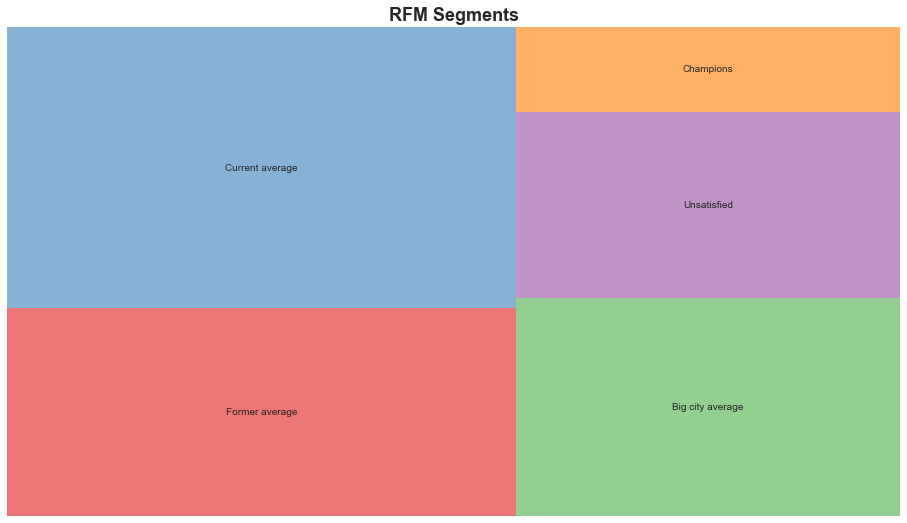

In [77]:
# Create our plot and resize it.
import plotly.express as px


labels = []
for key in client_labs.keys() :
    labels.append(client_labs[key])

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=df_rfm_agg.iloc[:, -1], 
              label=labels,
              alpha=.6,
              color=my_color)
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

# Evaluation temporal stability

In [78]:
df.shape

(2833, 13)

In [79]:
from sklearn import metrics
import datetime

In [80]:
# Creating a dataframe of orders only with client order which
# have ordered at least 2 times

df_orders = df_orders.loc[:, ['order_id',
                              'customer_unique_id',
                              'order_purchase_timestamp',
                              'order_tot_value',
                              'review_score',
                              'IBGE_RES_POP']]

df_orders['order_purchase_timestamp'] = \
        pd.to_datetime(df_orders['order_purchase_timestamp'],
                       format='%Y-%m-%d')

mask = df_orders.groupby(['customer_unique_id']).apply(lambda x: pd.Series({
        'frequency': x['order_id'].count()}))

mask = mask[mask['frequency'] > 1]
mask = df_orders['customer_unique_id']\
    .isin(mask.reset_index()['customer_unique_id'])

df_orders = df_orders.loc[mask]

In [81]:
# Function to create client dataset from a specific date
def time_selection(date_limit, df):
    mask = df['order_purchase_timestamp'] <= date_limit
    df = df.loc[mask]

    # Snapshot of the last order timestamp
    snapshot_date_ref = df['order_purchase_timestamp']\
        .max() + timedelta(days=1)

    # Clustering model features caculating
    df = df.groupby(['customer_unique_id']).apply(lambda x: pd.Series({
        'recency': (snapshot_date_ref
                    - x['order_purchase_timestamp'].max()).days,
        'frequency': x['order_id'].count(),
        'monetary_value': x['order_tot_value'].sum(),
        'avg_review_score': x['review_score'].mean(),
        'customer_city_size': x['IBGE_RES_POP'].mean()
    }))

    # We only keep client with at least 2 purchases
    df = df[df['frequency'] > 1]

    return(df)

2018-02-09 21:56:12
(1486, 5)
Days later: 0
ARi:  1.0 

2018-02-24 21:56:12
(1618, 5)
Days later: 15
ARi:  0.96 

2018-03-11 21:56:12
(1747, 5)
Days later: 30
ARi:  0.98 

2018-03-26 21:56:12
(1842, 5)
Days later: 45
ARi:  0.94 

2018-04-10 21:56:12
(1929, 5)
Days later: 60
ARi:  0.95 

2018-04-25 21:56:12
(2019, 5)
Days later: 75
ARi:  0.94 

2018-05-10 21:56:12
(2137, 5)
Days later: 90
ARi:  0.95 

2018-05-25 21:56:12
(2234, 5)
Days later: 105
ARi:  0.95 

2018-06-09 21:56:12
(2331, 5)
Days later: 120
ARi:  0.95 

2018-06-24 21:56:12
(2423, 5)
Days later: 135
ARi:  0.96 

2018-07-09 21:56:12
(2503, 5)
Days later: 150
ARi:  0.95 

2018-07-24 21:56:12
(2612, 5)
Days later: 165
ARi:  0.86 

2018-08-08 21:56:12
(2728, 5)
Days later: 180
ARi:  0.86 

2018-08-23 21:56:12
(2820, 5)
Days later: 195
ARi:  0.89 



Text(0, 0.5, 'ARI')

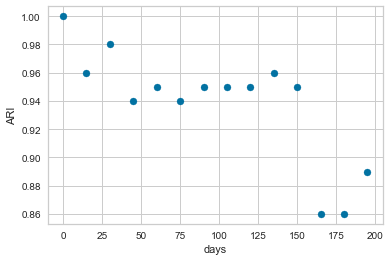

In [82]:
# Algorithme to check etime stability

# Initialisation
T0 = df_orders['order_purchase_timestamp'].max() \
    - datetime.timedelta(days=200)

F0 = time_selection(date_limit=T0,
                    df=df_orders)

scaler = StandardScaler()

F0_scaled = scaler.fit_transform(F0)

kmeans = KMeans(n_clusters=5,
                max_iter=1000,
                n_init=10,
                random_state=123)


ari_list = []
day_list = []

max_days = (df_orders['order_purchase_timestamp'].max() - T0).days

# Loop on every 15 days
for day in np.arange(0, max_days + 1, 15):

    T1 = T0 + datetime.timedelta(days=np.float64(day))
    print(T1)

    day_list.append(day)

    F1 = time_selection(date_limit=T1,
                        df=df_orders)
    print(F1.shape)

    F1_scaled = scaler.fit_transform(F1)

    C1_new = kmeans.fit_predict(F1_scaled)

    M0 = kmeans.fit(F0_scaled)
    C1_init = M0.predict(F1_scaled)

    ari = round(metrics.adjusted_rand_score(C1_new,
                                            C1_init),
                2)

    print('Days later:', day)
    print('ARi: ', ari, '\n')

    ari_list.append(ari)

plt.scatter(x=day_list,
            y=ari_list)
plt.xlabel('days')
plt.ylabel('ARI')

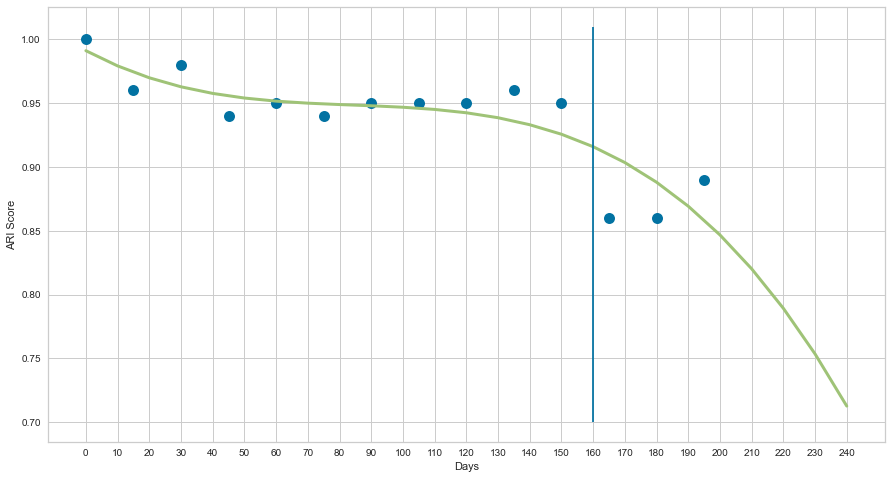

In [83]:
# Visualisation of ARI time evolution

plt.figure(figsize=(15, 8))
plt.plot(day_list, ari_list, 'o', ms=11)

model1 = np.poly1d(np.polyfit(day_list, ari_list, 3))
polyline = np.arange(0, 250, 10)

plt.plot(polyline,
         model1(polyline),
         '-',
         linewidth=3)

plt.vlines(x=160, ymin=.7, ymax=1.01)

plt.ylabel("ARI Score")
plt.xlabel("Days")
plt.xticks(np.arange(0, 250, 10))
plt.show()

## Conclusion

The model should be updated before 160 days 
    -> it is better to do a mainteance every 5 months. Indeed after 160 days the ARI score drop significantly.

### Visualisation for ppt

In [84]:
# function exploration continous variable
def EDA_continous(data):
    df_continous = data.select_dtypes(exclude=['object', 'datetime']).columns

    for col in df_continous:
        fig = plt.figure(figsize=(10, 2))

        plt.subplot(1, 2, 1)
        sns.histplot(x=data[col],
                     data=data,
                     kde=True)

        plt.subplot(1, 2, 2)
        sns.boxplot(x=data[col],
                    data=data)
        fig.tight_layout(pad=0.8)

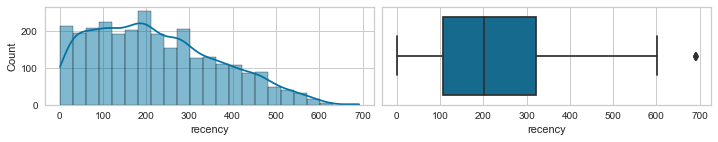

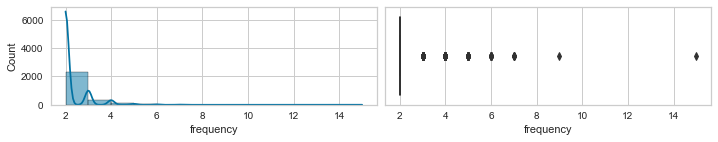

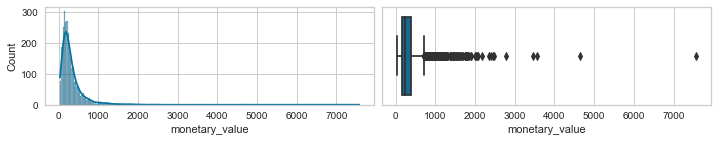

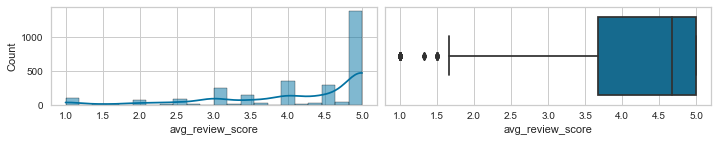

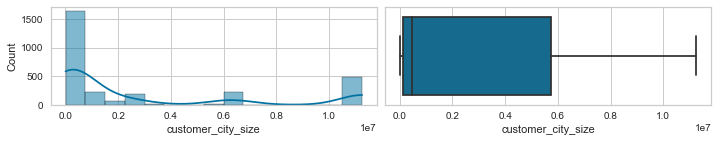

In [85]:
EDA_continous(df[selected_features])

In [86]:
# Correlation matrix between all numerical variables
corr = df[selected_features].corr('spearman')
corr.style.background_gradient(cmap='coolwarm')

,recency,frequency,monetary_value,avg_review_score,customer_city_size
recency,1.000000,0.098313,-0.033590,-0.034780,-0.042738
frequency,0.098313,1.000000,0.271220,0.006127,-0.002396
monetary_value,-0.033590,0.271220,1.000000,-0.047875,-0.044934
avg_review_score,-0.034780,0.006127,-0.047875,1.000000,-0.035040
customer_city_size,-0.042738,-0.002396,-0.044934,-0.035040,1.000000


In [87]:
# Spearman Correlation, pvalue for all features vs target
for row in corr.index:
    for col in corr.columns:
        if (row != col) and (corr.loc[row, col] > 0.5) or (corr.loc[row, col] < -0.5):
            spearman_coef, p_value = stats.spearmanr(np.array(df_client[row]), np.array(df_client[col]))
            if p_value < 0.05:
                print(f'{row :-<5} {col:-<50} {corr.loc[row, col]} {p_value} ')